In [1]:
%matplotlib inline
import _pickle as cp
import numpy as np
import matplotlib.pyplot as plt
import operator

class NBC:
    
    def __init__(self, feature_types):
        '''Constructor for initializing class attributes'''
        self.feature_types = feature_types
    
    def fit(self, X_train, Y_train):
        '''Method to fit an NBC classifier to the given data'''
        self.classwise_featurewise_params = self.get_classwise_featurewise_parameters(X_train, Y_train)
        self.class_probs = self.get_class_probability(Y_train)
        self.classes, counts = self.get_classes(Y_train)

    def predict(self, X_new):
        '''Method to predict the class of a newly given point'''
        class_conditional_probabilities = self.get_class_conditional_probability(X_new, self.classes, self.classwise_featurewise_params)
        final_probabilities = {clas: self.class_probs[clas] * class_conditional_probabilities[clas] for clas in self.class_probs}
        predicted_class = (max(final_probabilities, key=final_probabilities.get))
        return predicted_class, final_probabilities

    def get_class_conditional_probability(self, X_new, classes, classwise_featurewise_params):
        '''Method to compute the probability of each feature for each
        class. Real valued variables are modeled here using the Gaussian
        distribution. Categorical variables are modeled using the Multinoulli
        distribution and binary features are modeled using the Bernoulli
        distribution.'''
        
        # Modeling each feature for each class
        class_conditional_probability = {}
    
        for clas in classes:
            prob = 1
            col = 0
            for value in X_new:
                feature_type = self.feature_types[col]
                params = classwise_featurewise_params[clas][col]
                if (feature_type == 'b'):
                    prob = prob * self.get_Bernoulli_Prob(params, value)
                elif (feature_type == 'r'):
                    prob = prob * self.get_Gaussian_Prob(params, value)
                elif (feature_type == 'c'):
                    prob = prob * self.get_Multinoulli_Prob(params, value)
                col = col + 1
            class_conditional_probability[clas] = prob
        return class_conditional_probability


    def get_classwise_featurewise_parameters(self, X_train, Y_train):
        '''Method to compute probability distribution parameters for each feature
        and for each class.'''
        clas_feature_dict = {}
        columns = X_train.shape[1]
        classes, counts = self.get_classes(Y_train)
        for clas in classes:
            # Get the set of rows in X which correspond to this class
            X_train_clas = X_train[np.where(Y_train == clas)]
            parameters_for_class = {}
            for column in range(0,columns,1):
                X_column = X_train_clas[:,column]
                feature_type = self.feature_types[column]
                params = ''
                if (feature_type == 'b'):
                    params = self.fit_Bernoulli(X_column)
                elif (feature_type == 'r'):
                    params = self.fit_Gaussian(X_column)
                elif (feature_type == 'c'):
                    params = self.fit_Multinoulli(X_column)
                parameters_for_class[column] = params
            clas_feature_dict[clas] = parameters_for_class
        return clas_feature_dict
                    
        
    def get_class_probability(self, Y_train):
        '''Method to evaluate the prior probability for
        each class. It returns a dictionary, where the key is the class
        and the value is the prior probability of that class.'''
        unique_classes, counts = self.get_classes(Y_train)
        N = Y_train.size
        marginal_prob = {}
        for unique_class in unique_classes:
            index = np.where(unique_classes == unique_class)
            class_size = counts[index]
            marginal_prob[unique_class] = class_size/N
        return marginal_prob

    def get_classes(self, Y_train):
        '''Function to get a list of the distinct classes in the
        training set. We can figure out the number of classes from
        the size of this list'''
        return np.unique(Y_train, return_counts=True)

    def fit_Bernoulli(self, X):
        '''Method to fit a Bernoulli parameter to a given column.
        It is expected that the column will only contain binary
        variables 0 and 1.'''
        total = X.size
        num_ones = np.count_nonzero(X==1)
        smooth = 1
        return ((num_ones + smooth)/(total + (smooth * np.unique(X).size)))

    def get_Bernoulli_Prob(self, p, x):
        return ((p ** x) * (((1-p) ** (1-x))))
    
    def fit_Multinoulli(self, X):
        '''Method to fit a set of Multinoulli parameters to a given
        column. It is expected that the column will contain only a finite
        set of categories.'''
        categories, counts = self.get_classes(X)
        total = X.size
        multinoulli = {}
        for category in categories:
            index = np.where(categories == category)
            category_size = counts[index]
            multinoulli[category] = (category_size/total)
        return multinoulli

    def get_Multinoulli_Prob(self, probabilities, x):
        '''Method to return the multinoulli probability of occurrence
        of x. Please note that x is expected to be a categorical variable
        and probabilities is a dictionary containing the multinoulli parameters
        with respect to the categories.'''
        return probabilities[x]

    def fit_Gaussian(self, X):
        '''Method to fit the Gaussian parameters, mean and variance to a
        given column. It is expected that the column will contain real valued
        elements.'''
        mean = np.mean(X)
        var = ((np.std(X)) ** 2)
        return (mean, var)

    def get_Gaussian_Prob(self, params, x):
        '''Method to compute Gaussian probability based on given parameters.
        Please note that the params is a tuple containing first value as mean
        and second value as variance'''
        mean = params[0]
        var = params[1]
        eps = 1e-6
        exponent = np.exp(-(1/(2*(var+eps))) * ((x-mean)**2))
        return (exponent / (np.sqrt(2 * np.pi * (var + eps))))

In [11]:
%matplotlib inline
import _pickle as cp
import numpy as np
import matplotlib.pyplot as plt
import operator

class NBC_Log:
    
    def __init__(self, feature_types):
        '''Constructor for initializing class attributes'''
        self.feature_types = feature_types
    
    def fit(self, X_train, Y_train):
        '''Method to fit an NBC classifier to the given data'''
        self.classwise_featurewise_params = self.get_classwise_featurewise_parameters(X_train, Y_train)
        self.class_probs = self.get_class_probability(Y_train)
        self.classes, counts = self.get_classes(Y_train)

    def predict(self, X_new):
        '''Method to predict the class of a newly given point'''
        class_conditional_probabilities = self.get_class_conditional_probability(X_new, self.classes, self.classwise_featurewise_params)
        final_probabilities = {clas: self.class_probs[clas] + class_conditional_probabilities[clas] for clas in self.class_probs}
        predicted_class = (max(final_probabilities, key=final_probabilities.get))
        return predicted_class, final_probabilities

    def get_class_conditional_probability(self, X_new, classes, classwise_featurewise_params):
        '''Method to compute the probability of each feature for each
        class. Real valued variables are modeled here using the Gaussian
        distribution. Categorical variables are modeled using the Multinoulli
        distribution and binary features are modeled using the Bernoulli
        distribution.'''
        
        # Modeling each feature for each class
        class_conditional_probability = {}
    
        for clas in classes:
            prob = 1
            col = 0
            for value in X_new:
                feature_type = self.feature_types[col]
                params = classwise_featurewise_params[clas][col]
                if (feature_type == 'b'):
                    prob = prob + self.get_Bernoulli_Prob(params, value)
                elif (feature_type == 'r'):
                    prob = prob + self.get_Gaussian_Prob(params, value)
                elif (feature_type == 'c'):
                    prob = prob + self.get_Multinoulli_Prob(params, value)
                col = col + 1
            class_conditional_probability[clas] = prob
        return class_conditional_probability


    def get_classwise_featurewise_parameters(self, X_train, Y_train):
        '''Method to compute probability distribution parameters for each feature
        and for each class.'''
        clas_feature_dict = {}
        columns = X_train.shape[1]
        classes, counts = self.get_classes(Y_train)
        for clas in classes:
            # Get the set of rows in X which correspond to this class
            X_train_clas = X_train[np.where(Y_train == clas)]
            parameters_for_class = {}
            for column in range(0,columns,1):
                X_column = X_train_clas[:,column]
                feature_type = self.feature_types[column]
                params = ''
                if (feature_type == 'b'):
                    params = self.fit_Bernoulli(X_column)
                elif (feature_type == 'r'):
                    params = self.fit_Gaussian(X_column)
                elif (feature_type == 'c'):
                    params = self.fit_Multinoulli(X_column)
                parameters_for_class[column] = params
            clas_feature_dict[clas] = parameters_for_class
        return clas_feature_dict
                    
        
    def get_class_probability(self, Y_train):
        '''Method to evaluate the prior probability for
        each class. It returns a dictionary, where the key is the class
        and the value is the prior probability of that class.'''
        unique_classes, counts = self.get_classes(Y_train)
        N = Y_train.size
        marginal_prob = {}
        for unique_class in unique_classes:
            index = np.where(unique_classes == unique_class)
            class_size = counts[index]
            marginal_prob[unique_class] = np.log(class_size/N)
        return marginal_prob

    def get_classes(self, Y_train):
        '''Function to get a list of the distinct classes in the
        training set. We can figure out the number of classes from
        the size of this list'''
        return np.unique(Y_train, return_counts=True)

    def fit_Bernoulli(self, X):
        '''Method to fit a Bernoulli parameter to a given column.
        It is expected that the column will only contain binary
        variables 0 and 1.'''
        total = X.size
        num_ones = np.count_nonzero(X==1)
        smooth = 1
        return ((num_ones + smooth)/(total + (smooth * np.unique(X).size)))

    def get_Bernoulli_Prob(self, p, x):
        return (x * np.log(p) + (1-x) * np.log(1-p))
        #return ((p ** x) * (((1-p) ** (1-x))))
    
    def fit_Multinoulli(self, X):
        '''Method to fit a set of Multinoulli parameters to a given
        column. It is expected that the column will contain only a finite
        set of categories.'''
        categories, counts = self.get_classes(X)
        total = X.size
        multinoulli = {}
        for category in categories:
            index = np.where(categories == category)
            category_size = counts[index]
            multinoulli[category] = (category_size/total)
        return multinoulli

    def get_Multinoulli_Prob(self, probabilities, x):
        '''Method to return the multinoulli probability of occurrence
        of x. Please note that x is expected to be a categorical variable
        and probabilities is a dictionary containing the multinoulli parameters
        with respect to the categories.'''
        return np.log(probabilities[x])

    def fit_Gaussian(self, X):
        '''Method to fit the Gaussian parameters, mean and variance to a
        given column. It is expected that the column will contain real valued
        elements.'''
        mean = np.mean(X)
        var = ((np.std(X)) ** 2)
        return (mean, var)

    def get_Gaussian_Prob(self, params, x):
        '''Method to compute Gaussian log probability based on given parameters.
        Please note that the params is a tuple containing first value as mean
        and second value as variance'''
        mean = params[0]
        var = params[1]
        eps = 1e-6
        exponent = -(1/(2*(var+eps))) * ((x-mean)**2)
        return (exponent + np.log((np.sqrt(2 * np.pi * (var + eps)))))

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X,y = iris.data, iris.target

N, D = X.shape
X_ = np.array(X)
y_ = np.array(y)
N_train = int(0.8 * N)

X_train = X_[:N_train]
X_test = X_[N_train:]
y_train = y_[:N_train]
y_test = y_[N_train:]

print(X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)


(120, 4)
(30, 4)
(120,)
(30,)


In [4]:
nbc = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc.fit(X_train, y_train)
Y_hat = []
for X in X_test:
    Y_class, prob_dist = nbc.predict(X)
    Y_hat = Y_hat + [Y_class]
test_accuracy = np.mean(Y_hat == y_test)
print (test_accuracy)

0.933333333333


In [5]:
from sklearn.linear_model import LogisticRegression

# Since C is the inverse of the regularization strength and the value of Lambda = 0.1, I am choosing C as 10 here.
log_regress = LogisticRegression(C=5, penalty='l1', max_iter = 100)

log_regress.fit(X_train, y_train)
y_hat = log_regress.predict(X_test)
test_accuracy = np.mean(y_hat == y_test)
print (test_accuracy)

0.733333333333


In [6]:
# Testing on the Voting data set
X_voting, y_voting = cp.load(open('voting.pickle', 'rb'))

print (X_voting.shape)
print (y_voting.shape)


(232, 16)
(232,)


In [7]:
# Defining a method for shuffling any given dataset
def shuffle(X, y):
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    return Xtrain, ytrain, Xtest, ytest

# Defining a method for breaking a dataset into training and test sets
def partial_training_set(X, y, k):
    N, D = X.shape
    Ntrain = int(k * N)
    X_train = X[:Ntrain]
    y_train = y[:Ntrain]
    X_test = X[Ntrain:]
    y_test = y[Ntrain:]
    return X_train, y_train

In [8]:
# Experiments section
# Experiment 1: Iris dataset, NBC classifier
X_iris, y_iris = iris.data, iris.target
error_matrix_iris_nbc = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_iris, y_iris)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        nbc = NBC(feature_types = ['r', 'r', 'r', 'r'])
        nbc.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = []
        for x in X_shuffled_test:
            y_class, prob_dist = nbc.predict(x)
            y_hat = y_hat + [y_class]
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_iris_nbc[p-1][q-1] = test_error

error_matrix_mean_iris_nbc = error_matrix_iris_nbc.mean(0)
print (error_matrix_mean_iris_nbc)

[ 0.213       0.0739      0.05593333  0.05133333  0.04933333  0.04743333
  0.04646667  0.04586667  0.0456      0.04586667]


In [9]:
# Experiments section
# Experiment 2: Iris dataset, Logistic regression classifier
error_matrix_iris_logistic = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_iris, y_iris)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        logistic_regression = LogisticRegression(C = 10, penalty='l1')
        logistic_regression.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = []
        y_hat = logistic_regression.predict(X_shuffled_test)
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_iris_logistic[p-1][q-1] = test_error

error_matrix_mean_logistic_nbc = error_matrix_iris_logistic.mean(0)
print (error_matrix_mean_logistic_nbc)

[ 0.1539      0.0848      0.06583333  0.0564      0.0491      0.0448
  0.04286667  0.04076667  0.03906667  0.0383    ]


In [12]:
# Experiments section
# Experiment 1.1: Iris dataset, NBC classifier
X_iris, y_iris = iris.data, iris.target
error_matrix_iris_nbc = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_iris, y_iris)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        nbc = NBC_Log(feature_types = ['r', 'r', 'r', 'r'])
        nbc.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = []
        for x in X_shuffled_test:
            y_class, prob_dist = nbc.predict(x)
            y_hat = y_hat + [y_class]
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_iris_nbc[p-1][q-1] = test_error

error_matrix_mean_iris_nbc2 = error_matrix_iris_nbc.mean(0)
print (error_matrix_mean_iris_nbc2)

[ 0.23036667  0.09063333  0.0708      0.06546667  0.06283333  0.062
  0.06186667  0.06186667  0.06126667  0.06096667]


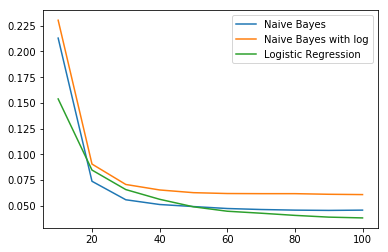

In [13]:
# Plotting for the Iris dataset
x_plot = range(10,110,10)
plt.plot(x_plot, error_matrix_mean_iris_nbc, label = 'Naive Bayes')
plt.plot(x_plot, error_matrix_mean_iris_nbc2, label = 'Naive Bayes with log')
plt.plot(x_plot, error_matrix_mean_logistic_nbc, label = 'Logistic Regression')
plt.legend()
plt.show()

In [15]:
# Experiments section
# Experiment 3: Voting dataset, NBC classifier
error_matrix_voting_nbc = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_voting, y_voting)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        nbc = NBC(feature_types = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])
        nbc.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = []
        for x in X_shuffled_test:
            y_class, prob_dist = nbc.predict(x)
            y_hat = y_hat + [y_class]
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_voting_nbc[p-1][q-1] = test_error

error_matrix_mean_voting_nbc = error_matrix_voting_nbc.mean(0)
print (error_matrix_mean_voting_nbc)

[ 0.13553191  0.08402128  0.07419149  0.07346809  0.07376596  0.07451064
  0.07653191  0.07838298  0.08021277  0.08176596]


In [16]:
# Experiments section
# Experiment 3.1: Voting dataset, NBC classifier
error_matrix_voting_nbc = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_voting, y_voting)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        nbc = NBC_Log(feature_types = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])
        nbc.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = []
        for x in X_shuffled_test:
            y_class, prob_dist = nbc.predict(x)
            y_hat = y_hat + [y_class]
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_voting_nbc[p-1][q-1] = test_error

error_matrix_mean_voting_nbc2 = error_matrix_voting_nbc.mean(0)
print (error_matrix_mean_voting_nbc2)

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars


[ 0.42680851  0.2837234   0.20248936  0.14702128  0.1187234   0.10119149
  0.09074468  0.08676596  0.08525532  0.08391489]


In [17]:
# Experiments section
# Experiment 4: Voting dataset, Logistic regression classifier
error_matrix_voting_logistic = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_voting, y_voting)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        logistic_regression = LogisticRegression()
        logistic_regression.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = logistic_regression.predict(X_shuffled_test)
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_voting_logistic[p-1][q-1] = test_error

error_matrix_mean_voting_logistic = error_matrix_voting_logistic.mean(0)
print (error_matrix_mean_voting_logistic)

[ 0.09608511  0.07682979  0.06702128  0.05906383  0.05546809  0.05244681
  0.04987234  0.0482766   0.0472766   0.04568085]


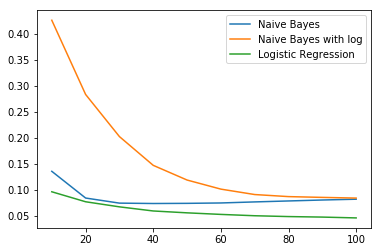

In [18]:
# Plotting for the Voting dataset
x_plot = range(10,110,10)
plt.plot(x_plot, error_matrix_mean_voting_nbc, label = 'Naive Bayes')
plt.plot(x_plot, error_matrix_mean_voting_nbc2, label = 'Naive Bayes with log')
plt.plot(x_plot, error_matrix_mean_voting_logistic, label = 'Logistic Regression')
plt.legend()
plt.show()

In [19]:
# Optional
# Loading the full voting dataset
X_voting_full, y_voting_full = cp.load(open('voting-full.pickle', 'rb'))

print (X_voting_full.shape)
print (y_voting_full.shape)

(435, 16)
(435,)


In [20]:
# NBC which can deal with missing values in training and test sets.
%matplotlib inline
import _pickle as cp
import numpy as np
import matplotlib.pyplot as plt
import operator

class NBC_Modified:
    
    def __init__(self, feature_types):
        '''Constructor for initializing class attributes'''
        self.feature_types = feature_types
    
    def fit(self, X_train, Y_train):
        '''Method to fit an NBC classifier to the given data'''
        self.classwise_featurewise_params = self.get_classwise_featurewise_parameters(X_train, Y_train)
        self.class_probs = self.get_class_probability(Y_train)
        self.classes, counts = self.get_classes(Y_train)

    def predict(self, X_new):
        '''Method to predict the class of a newly given point'''
        class_conditional_probabilities = self.get_class_conditional_probability(X_new, self.classes, self.classwise_featurewise_params)
        final_probabilities = {clas: self.class_probs[clas] * class_conditional_probabilities[clas] for clas in self.class_probs}
        predicted_class = (max(final_probabilities, key=final_probabilities.get))
        return predicted_class, final_probabilities

    def get_class_conditional_probability(self, X_new, classes, classwise_featurewise_params):
        '''Method to compute the probability of each feature for each
        class. Real valued variables are modeled here using the Gaussian
        distribution. Categorical variables are modeled using the Multinoulli
        distribution and binary features are modeled using the Bernoulli
        distribution.'''
        
        # Modeling each feature for each class
        class_conditional_probability = {}
    
        for clas in classes:
            prob = 1
            col = 0
            for value in X_new:
                if (value == 2):
                    prob = prob * 1
                else:
                    feature_type = self.feature_types[col]
                    params = classwise_featurewise_params[clas][col]
                    if (feature_type == 'b'):
                        prob = prob * self.get_Bernoulli_Prob(params, value)
                    elif (feature_type == 'r'):
                        prob = prob * self.get_Gaussian_Prob(params, value)
                    elif (feature_type == 'c'):
                        prob = prob * self.get_Multinoulli_Prob(params, value)
                    col = col + 1
                class_conditional_probability[clas] = prob
        return class_conditional_probability


    def get_classwise_featurewise_parameters(self, X_train, Y_train):
        '''Method to compute probability distribution parameters for each feature
        and for each class.'''
        clas_feature_dict = {}
        columns = X_train.shape[1]
        classes, counts = self.get_classes(Y_train)
        for clas in classes:
            # Get the set of rows in X which correspond to this class
            X_train_clas = X_train[np.where(Y_train == clas)]
            parameters_for_class = {}
            for column in range(0,columns,1):
                X_column = X_train_clas[:,column]
                feature_type = self.feature_types[column]
                params = ''
                if (feature_type == 'b'):
                    params = self.fit_Bernoulli(X_column)
                elif (feature_type == 'r'):
                    params = self.fit_Gaussian(X_column)
                elif (feature_type == 'c'):
                    params = self.fit_Multinoulli(X_column)
                parameters_for_class[column] = params
            clas_feature_dict[clas] = parameters_for_class
        return clas_feature_dict
                    
        
    def get_class_probability(self, Y_train):
        '''Method to evaluate the prior probability for
        each class. It returns a dictionary, where the key is the class
        and the value is the prior probability of that class.'''
        unique_classes, counts = self.get_classes(Y_train)
        N = Y_train.size
        marginal_prob = {}
        for unique_class in unique_classes:
            index = np.where(unique_classes == unique_class)
            class_size = counts[index]
            marginal_prob[unique_class] = class_size/N
        return marginal_prob

    def get_classes(self, Y_train):
        '''Function to get a list of the distinct classes in the
        training set. We can figure out the number of classes from
        the size of this list'''
        return np.unique(Y_train, return_counts=True)

    def fit_Bernoulli(self, X):
        '''Method to fit a Bernoulli parameter to a given column.
        It is expected that the column will only contain binary
        variables 0 and 1. If a column has missing values, it is simply
        ignored.'''
        num_ones = np.count_nonzero(X==1)
        num_zeros = np.count_nonzero(X==0)
        smooth = 1
        return ((num_ones + smooth)/((num_ones + num_zeros) + (smooth * 2)))

    def get_Bernoulli_Prob(self, p, x):
        return ((p ** x) * (((1-p) ** (1-x))))
    
    def fit_Multinoulli(self, X):
        '''Method to fit a set of Multinoulli parameters to a given
        column. It is expected that the column will contain only a finite
        set of categories.'''
        categories, counts = self.get_classes(X)
        total = X.size
        multinoulli = {}
        for category in categories:
            index = np.where(categories == category)
            category_size = counts[index]
            multinoulli[category] = (category_size/total)
        return multinoulli

    def get_Multinoulli_Prob(self, probabilities, x):
        '''Method to return the multinoulli probability of occurrence
        of x. Please note that x is expected to be a categorical variable
        and probabilities is a dictionary containing the multinoulli parameters
        with respect to the categories.'''
        return probabilities[x]

    def fit_Gaussian(self, X):
        '''Method to fit the Gaussian parameters, mean and variance to a
        given column. It is expected that the column will contain real valued
        elements.'''
        mean = np.mean(X)
        var = ((np.std(X)) ** 2)
        return (mean, var)

    def get_Gaussian_Prob(self, params, x):
        '''Method to compute Gaussian probability based on given parameters.
        Please note that the params is a tuple containing first value as mean
        and second value as variance'''
        mean = params[0]
        var = params[1]
        eps = 1e-6
        exponent = np.exp(-(1/(2*(var+eps))) * ((x-mean)**2))
        return (exponent / (np.sqrt(2 * np.pi * (var + eps))))

In [15]:
N, D = X_voting_full.shape
Ntrain = int(0.8 * N)
X_voting_train = X_voting_full[:Ntrain]
y_voting_train = y_voting_full[:Ntrain]
X_voting_test = X_voting_full[Ntrain:]
y_voting_test = y_voting_full[Ntrain:]

nbc_mod = NBC_Modified(feature_types = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])
nbc_mod.fit(X_voting_train, y_voting_train)

y_hat = []
for xnew in X_voting_test:
    y_label, dist = nbc_mod.predict(xnew)
    y_hat = y_hat + [y_label]

test_accuracy = np.mean(y_hat == y_voting_test)
print(test_accuracy)

0.919540229885


In [16]:
# Logistic regression with missing values
# modifying the data set by filling up missing values with 0

X_voting_full[X_voting_full == 2] = 0
N, D = X_voting_full.shape
Ntrain = int(0.8 * N)
X_voting_train = X_voting_full[:Ntrain]
y_voting_train = y_voting_full[:Ntrain]
X_voting_test = X_voting_full[Ntrain:]
y_voting_test = y_voting_full[Ntrain:]

log_regression = LogisticRegression()
log_regression.fit(X_voting_train, y_voting_train)
y_hat = log_regression.predict(X_voting_test)

test_accuracy = np.mean(y_hat == y_voting_test)
print (test_accuracy)

0.965517241379


In [17]:
# Optional
# Loading the full voting dataset
X_voting_full, y_voting_full = cp.load(open('voting-full.pickle', 'rb'))

print (X_voting_full.shape)
print (y_voting_full.shape)

(435, 16)
(435,)


In [18]:
# Experiments section
# Experiment 5: Voting_full dataset, NBC classifier
error_matrix_voting_full_nbc = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_voting_full, y_voting_full)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        nbc = NBC(feature_types = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])
        nbc.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = []
        for x in X_shuffled_test:
            y_class, prob_dist = nbc.predict(x)
            y_hat = y_hat + [y_class]
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_voting_full_nbc[p-1][q-1] = test_error

error_matrix_mean_voting_full_nbc = error_matrix_voting_full_nbc.mean(0)
print (error_matrix_mean_voting_full_nbc)

/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


[ 0.11888506  0.10072414  0.10072414  0.10250575  0.10414943  0.10473563
  0.10526437  0.10551724  0.10550575  0.10566667]


In [19]:
# Experiments section
# Experiment 6: Voting_full dataset, Logistic regression classifier
error_matrix_voting_full_logistic = np.zeros((1000,10))

for p in range(1,1001,1):
    X_shuffled_train, y_shuffled_train, X_shuffled_test, y_shuffled_test = shuffle(X_voting_full, y_voting_full)
    for q in range(1,11,1):
        X_shuffled_train_partial, y_shuffled_train_partial = partial_training_set(X_shuffled_train, y_shuffled_train, (q/10))
        logistic_regression = LogisticRegression()
        logistic_regression.fit(X_shuffled_train_partial, y_shuffled_train_partial)
        y_hat = logistic_regression.predict(X_shuffled_test)
        test_error = np.mean(y_hat != y_shuffled_test)
        error_matrix_voting_full_logistic[p-1][q-1] = test_error

error_matrix_mean_voting_full_logistic = error_matrix_voting_full_logistic.mean(0)
print (error_matrix_mean_voting_full_logistic)

[ 0.0924023   0.07652874  0.06985057  0.06682759  0.06525287  0.06216092
  0.06090805  0.05951724  0.05828736  0.05682759]


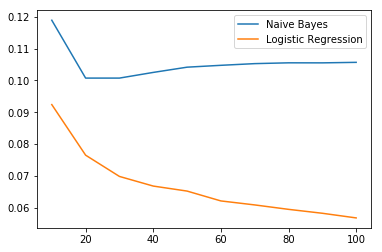

In [20]:
# Plotting for the Voting full dataset
x_plot = range(10,110,10)
plt.plot(x_plot, error_matrix_mean_voting_full_nbc, label = 'Naive Bayes')
plt.plot(x_plot, error_matrix_mean_voting_full_logistic, label = 'Logistic Regression')
plt.legend()
plt.show()